In [1]:
import numpy as np 
import pandas as pd
import logging

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

import torchvision
from torchvision import transforms as T
from PIL import Image

import os, time, random, argparse

from dataset import RSNADataset
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch_xla
import torch_xla.distributed.data_parallel as dp
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm

In [3]:
inference_transforms = T.Compose([
    Image.fromarray,
    T.ToTensor(),
    T.Normalize(mean=(0.345, 0.323, 0.271), std=(0.225, 0.324, 0.429))
    ])

In [4]:
train_csv = '../data/stage_1_train.csv'
test_csv = '../data/stage_1_sample_submission.csv'

In [5]:
patient, label = extract_patient(train_csv, True)

In [6]:
patient = extract_patient(test_csv, False)

In [7]:
DEVICE = xm.xla_device()

In [8]:
model = torchvision.models.resnet34()
model.fc = torch.nn.Linear(model.fc.in_features, 6)

In [9]:
model.load_state_dict(torch.load('../model.pth'))

<All keys matched successfully>

In [10]:
model = model.to(DEVICE)

In [11]:
ds = RSNADataset(patient[:100], path='../data/stage_1_test_images', transform=inference_transforms)

In [12]:
loader = D.DataLoader(ds, batch_size=16,
                          shuffle=False, num_workers=4)

In [13]:
patientid = []
score = np.empty((0,6))
for images, patient_name in loader:
    out = model(images.to(DEVICE))
    patientid += list(patient_name)
    score = np.concatenate([score, out.detach().cpu().sigmoid().numpy()])

In [14]:
prediction_to_df(score, patientid, 'test.csv')

In [16]:
np.round_(score, decimals=3)

array([[0.03 , 0.045, 0.023, 0.041, 0.02 , 0.048],
       [0.028, 0.034, 0.017, 0.068, 0.092, 0.125],
       [0.021, 0.014, 0.012, 0.004, 0.004, 0.006],
       [0.029, 0.04 , 0.024, 0.01 , 0.028, 0.032],
       [0.02 , 0.014, 0.012, 0.016, 0.008, 0.015],
       [0.112, 0.209, 0.331, 0.965, 0.764, 0.995],
       [0.027, 0.036, 0.018, 0.011, 0.013, 0.021],
       [0.023, 0.028, 0.013, 0.01 , 0.013, 0.016],
       [0.092, 0.047, 0.012, 0.142, 0.971, 0.969],
       [0.016, 0.029, 0.095, 0.044, 0.01 , 0.062],
       [0.072, 0.079, 0.026, 0.038, 0.387, 0.381],
       [0.025, 0.056, 0.139, 0.162, 0.171, 0.429],
       [0.018, 0.028, 0.02 , 0.007, 0.011, 0.01 ],
       [0.025, 0.042, 0.028, 0.023, 0.061, 0.081],
       [0.02 , 0.052, 0.025, 0.03 , 0.055, 0.092],
       [0.028, 0.039, 0.028, 0.019, 0.027, 0.043],
       [0.032, 0.022, 0.018, 0.016, 0.019, 0.025],
       [0.023, 0.019, 0.014, 0.005, 0.009, 0.01 ],
       [0.023, 0.044, 0.019, 0.011, 0.028, 0.042],
       [0.031, 0.033, 0.019, 0.

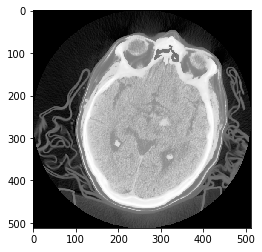

In [15]:
plt.imshow(ds[133160][0], cmap=plt.cm.bone)

In [16]:
test_ds = RSNADataset(extract_patient(test_csv, False), path='../data/stage_1_test_images')

In [24]:
test_ds[13160][1]

'4b34a18bf'

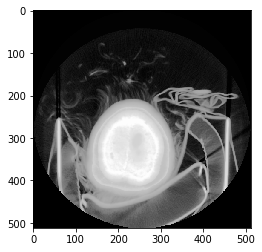

In [27]:
plt.imshow(test_ds[6289][0], cmap=plt.cm.bone)

In [45]:
model_name = 'resnext50_32x4d'

In [46]:
model = eval(f'torchvision.models.{model_name}(pretrained=True, progress=False)')

try:
    model.classifier = torch.nn.Linear(model.classifier.in_features, 6)
except:
    try:
        model.fc = torch.nn.Linear(model.fc.in_features, 6)
    except:
        print('Unknown model classifier name')

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /home/kaktys_leha/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


In [28]:
import torchvision

In [ ]:
torchvision.models.resnet101
torchvision.models.resnet152
torchvision.models.resnet18
torchvision.models.resnet34
torchvision.models.resnext101_32x8d()